# Autoencoder FNN for CIFAR10

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Autoencoder-FNN-for-CIFAR10" data-toc-modified-id="Autoencoder-FNN-for-CIFAR10-1">Autoencoder FNN for CIFAR10</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#encoder와-decoder를-직접-구현하여-autoencoder-만들기" data-toc-modified-id="encoder와-decoder를-직접-구현하여-autoencoder-만들기-1.0.1">encoder와 decoder를 직접 구현하여 autoencoder 만들기</a></span></li><li><span><a href="#compile,-fit" data-toc-modified-id="compile,-fit-1.0.2">compile, fit</a></span></li><li><span><a href="#시각화" data-toc-modified-id="시각화-1.0.3">시각화</a></span></li><li><span><a href="#이미지에-노이즈-추가-후-autoencoder로-제거하기" data-toc-modified-id="이미지에-노이즈-추가-후-autoencoder로-제거하기-1.0.4">이미지에 노이즈 추가 후 autoencoder로 제거하기</a></span><ul class="toc-item"><li><span><a href="#Noise-image-만들기" data-toc-modified-id="Noise-image-만들기-1.0.4.1">Noise image 만들기</a></span></li><li><span><a href="#Noise-제거-하기" data-toc-modified-id="Noise-제거-하기-1.0.4.2">Noise 제거 하기</a></span></li></ul></li></ul></li></ul></li></ul></div>

Using TensorFlow backend.


channels_last
170500096/170498071 [==============================] - 65s 0us/step
train_images <class 'numpy.ndarray'> (50000, 32, 32, 3) uint8
train_labels <class 'numpy.ndarray'> (50000, 1) uint8
test_images <class 'numpy.ndarray'> (10000, 32, 32, 3) uint8
test_labels <class 'numpy.ndarray'> (10000, 1) int64


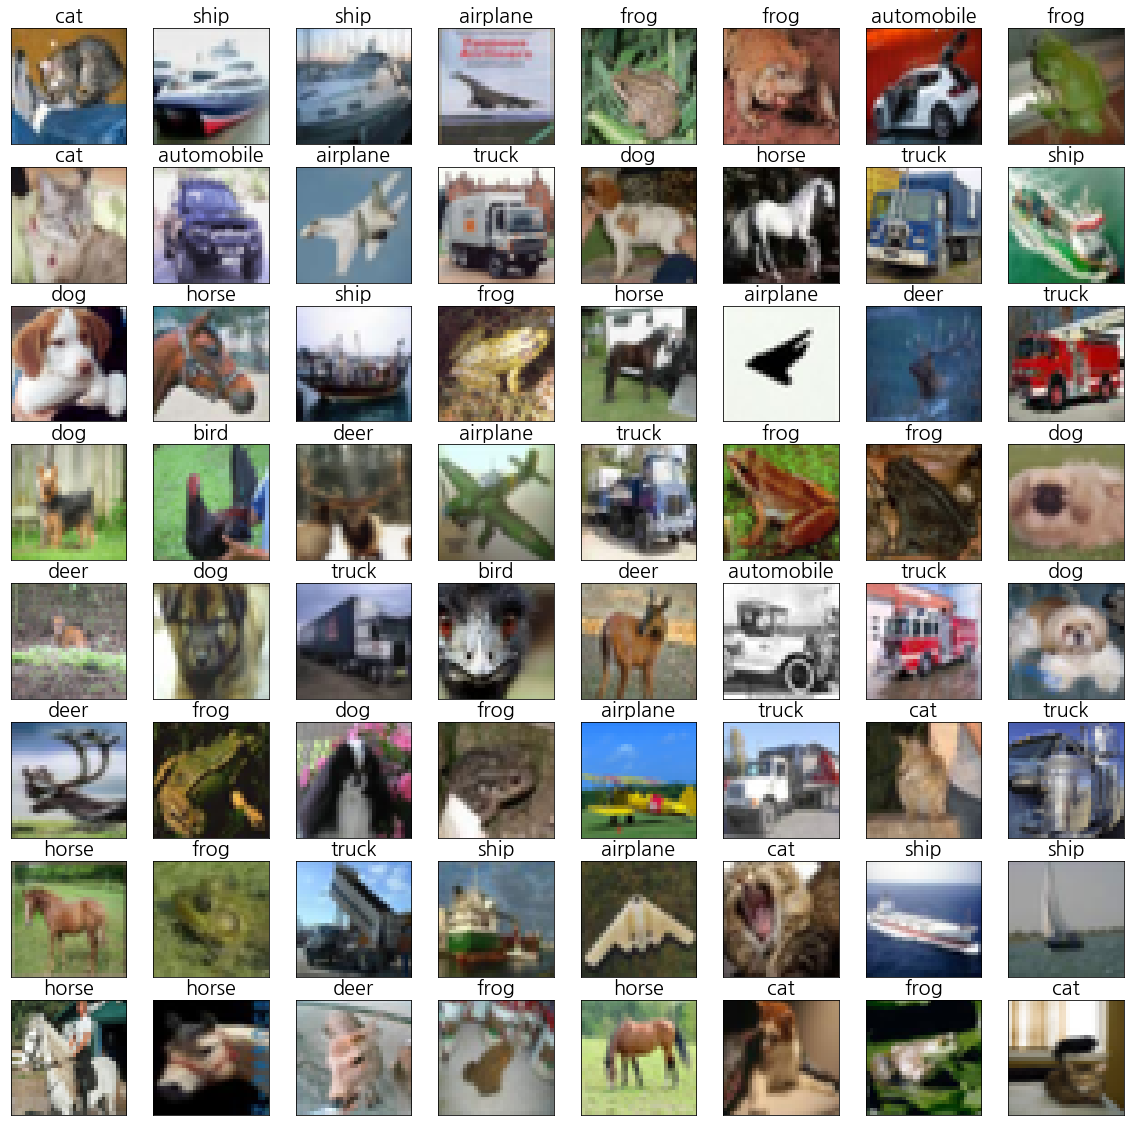

In [1]:
from keras import datasets, layers, models, utils
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

K.set_image_data_format( 'channels_last' )
print( K.image_data_format() )

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

print( 'train_images', type(train_images), train_images.shape, train_images.dtype )
print( 'train_labels', type(train_labels), train_labels.shape, train_labels.dtype )
print( 'test_images', type(test_images), test_images.shape, test_images.dtype )
print( 'test_labels', type(test_labels), test_labels.shape, test_labels.dtype )

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck' ]

plt.figure( figsize=(20,20) )
for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.title( class_names[test_labels[i][0]], {'fontsize':20} )
    plt.imshow( test_images[i] )

In [2]:
_, H, W, C = train_images.shape
train_x = ( train_images / 255 ).astype('float32')
test_x = ( test_images / 255 ).astype('float32')
print( 'test_x', type(test_x), test_x.shape, test_x.dtype )

test_x <class 'numpy.ndarray'> (10000, 32, 32, 3) float32


In [3]:
num_classes = 10

print( 'test_labels', test_labels.shape, test_labels.dtype )
print( 'test_labels[0] =', test_labels[0] )

train_y = utils.to_categorical(train_labels, num_classes)
test_y = utils.to_categorical(test_labels, num_classes)

print( 'test_y', test_y.shape, test_y.dtype )
print( 'test_y[0] =', test_y[0] )

test_labels (10000, 1) int64
test_labels[0] = [3]
test_y (10000, 10) float32
test_y[0] = [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


### encoder와 decoder를 직접 구현하여 autoencoder 만들기

In [4]:
x = layers.Input(shape=(H, W, C), name='x')
e = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='e1')(x)
e = layers.MaxPooling2D((2,2), name='e2')(e)
e = layers.Conv2D(8, (3,3), padding='same', activation='relu', name='e3')(e)
e = layers.MaxPooling2D((2,2), name='e4')(e)
e = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='e5')(e)

z = layers.Conv2D(1, (3,3), padding='same', activation='relu', name='z')(e)

encoder = models.Model(x, z)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
z = layers.Input(shape=encoder.get_layer('z').output_shape[1:], name='z')

d = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='d1')(z)
d = layers.UpSampling2D((2,2), name='d2')(d)
d = layers.Conv2D(8, (3,3), padding='same', activation='relu', name='d3')(d)
d = layers.UpSampling2D((2,2), name='d4')(d)
d = layers.Conv2D(4, (3,3), padding='same', activation='relu', name='d5')(d)

y = layers.Conv2D(3, (3,3), padding='same', name='y')(d)

decoder = models.Model(z, y)

In [10]:
autoencoder = models.Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

encoder.summary()
decoder.summary()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x (InputLayer)               (None, 32, 32, 3)         0         
_________________________________________________________________
e1 (Conv2D)                  (None, 32, 32, 4)         112       
_________________________________________________________________
e2 (MaxPooling2D)            (None, 16, 16, 4)         0         
_________________________________________________________________
e3 (Conv2D)                  (None, 16, 16, 8)         296       
_________________________________________________________________
e4 (MaxPooling2D)            (None, 8, 8, 8)           0         
_________________________________________________________________
e5 (Conv2D)                  (None, 8, 8, 4)           292       
_________________________________________________________________
z (Conv2D)                   (None, 8, 8, 1)           37        
Total para

### compile, fit

In [11]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [12]:
hist = autoencoder.fit(train_x, train_x, batch_size=128, epochs=20, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 60s 2ms/step - loss: 0.0593 - acc: 0.3664 - val_loss: 0.0246 - val_acc: 0.3892
Epoch 2/20
40000/40000 [==============================] - 55s 1ms/step - loss: 0.0219 - acc: 0.4077 - val_loss: 0.0198 - val_acc: 0.4034
Epoch 3/20
40000/40000 [==============================] - 43s 1ms/step - loss: 0.0188 - acc: 0.4169 - val_loss: 0.0178 - val_acc: 0.4240
Epoch 4/20
40000/40000 [==============================] - 42s 1ms/step - loss: 0.0173 - acc: 0.4250 - val_loss: 0.0168 - val_acc: 0.4055
Epoch 5/20
40000/40000 [==============================] - 42s 1ms/step - loss: 0.0166 - acc: 0.4319 - val_loss: 0.0163 - val_acc: 0.4107
Epoch 6/20
40000/40000 [==============================] - 43s 1ms/step - loss: 0.0162 - acc: 0.4372 - val_loss: 0.0159 - val_acc: 0.4040
Epoch 7/20
40000/40000 [==============================] - 44s 1ms/step - loss: 0

### 시각화

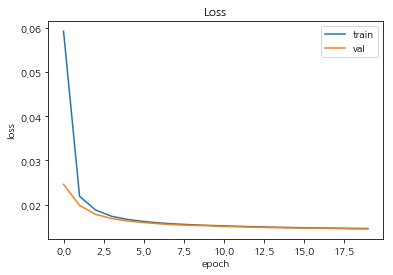

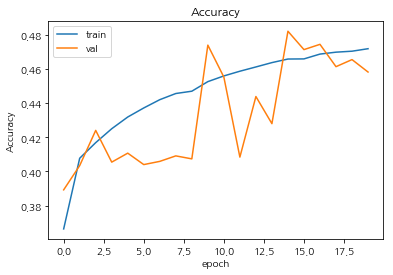

10000/10000 [==============================] - 3s 305us/step
[loss, accuracy]: [0.01451811612546444, 0.45834619140625]


In [13]:
from modules.plot_history import plot_loss, plot_acc

plot_loss(hist, 'Loss')
plt.show()
plot_acc(hist, 'Accuracy')
plt.show()

performance_test = autoencoder.evaluate(test_x, test_x, batch_size=128)
print('[loss, accuracy]:', performance_test)

In [14]:
# decoded_imgs = autoencoder.predict(test_x)
encoded_imgs = encoder.predict(test_x)
decoded_imgs = decoder.predict(encoded_imgs)

print( 'encoded_imgs.shape =', encoded_imgs.shape )
print( 'decoded_imgs.shape =', decoded_imgs.shape )

encoded_imgs.shape = (10000, 8, 8, 1)
decoded_imgs.shape = (10000, 32, 32, 3)


TypeError: Invalid dimensions for image data

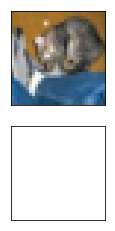

In [16]:
plt.figure( figsize=(20,6) )
n = 10

for i in range(0, n):
    plt.subplot(3, 10, i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( test_x[i] )

    plt.subplot(3, 10, 10+i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( encoded_imgs[i] )

    plt.subplot(3, 10, 20+i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( decoded_imgs[i] )

plt.show()

### 이미지에 노이즈 추가 후 autoencoder로 제거하기

#### Noise image 만들기

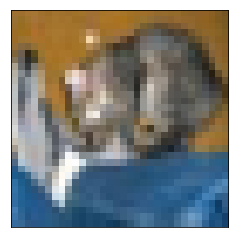

In [17]:
plt.xticks([]); plt.yticks([])
plt.imshow( test_x[0] )
plt.show()

In [20]:
noise_img = np.zeros_like(test_x[0])

num_noise_point = 8
noise_posx = np.random.randint(0, H, num_noise_point)
noise_posy = np.random.randint(0, W, num_noise_point)

for i in range(num_noise_point):
    noise_img[noise_posx[i], noise_posy[i], 0] = 1

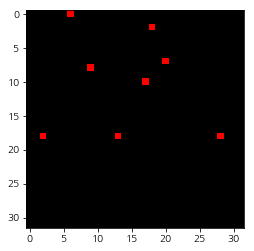

In [21]:
plt.imshow(noise_img)

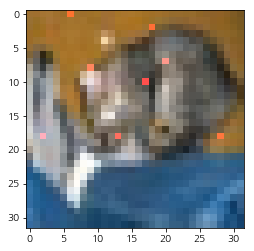

In [22]:
test_x_noise = test_x[0] + noise_img
test_x_noise = np.clip(test_x_noise, 0, 1)
plt.imshow(test_x_noise)

In [23]:
test_x_noise = np.clip(test_x + noise_img, 0, 1)

#### Noise 제거 하기

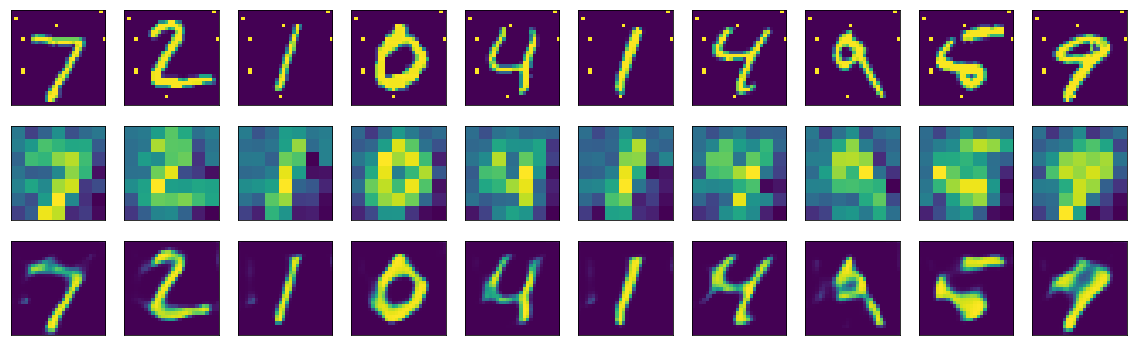

In [43]:
encoded_imgs = encoder.predict(test_x_noise)
decoded_imgs = decoder.predict(encoded_imgs)

plt.figure( figsize=(20,6) )
n = 10

for i in range(0, n):
    plt.subplot(3, 10, i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( test_x_noise[i] )

    plt.subplot(3, 10, 10+i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( encoded_imgs[i] * 0.6 )

    plt.subplot(3, 10, 20+i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow( decoded_imgs[i] )

plt.show()